## About

https://www.kaggle.com/drcapa/facial-expression-eda-cnn
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

The data set consits of 48x48 pixel images of faces.
There is a total of seven categories with a categorizing number:

Angry (0)
Disgust (1)
Fear (2)
Happy (3)
Sad (4)
Surprise (5)
Neutral (6)



## Libraries
Loading of some standard libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf


from keras.models import Model
from keras.optimizers import Adam, Adagrad, RMSprop
from keras import regularizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras_vggface.vggface import VGGFace
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Reshape, Flatten

## Loading data and paths

In [2]:
import os 
dir_path = os.getcwd()

In [3]:
data = pd.read_csv(dir_path + "/data/icml_face_data.csv")

In [4]:
train_images = pd.read_csv(dir_path + "/data/train.csv")

In [5]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## Helper Functions

In [6]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels and pixel data
        output: image and label array """
    
    # Creates two np arrays.
    # 1st is an array with the length of the dataframe, and each element in the array is a 48x48 array
    image_array = np.zeros(shape=(len(data), 48, 48))
    # 2nd is an array that creates an array where each element is a number representing the emotion from the dataframe
    image_label = np.array(list(map(int, data['emotion'])))
    
    # We iterate through the dataframe row by row, inserting each row as element in the array and separating
    # each value separated with a space and adding it as an element.
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [7]:
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [8]:
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [9]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

In [10]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [11]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [12]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [13]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [14]:
# We transform the the labels to proper vectors to make it usable for the model to use
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

## Some image examples

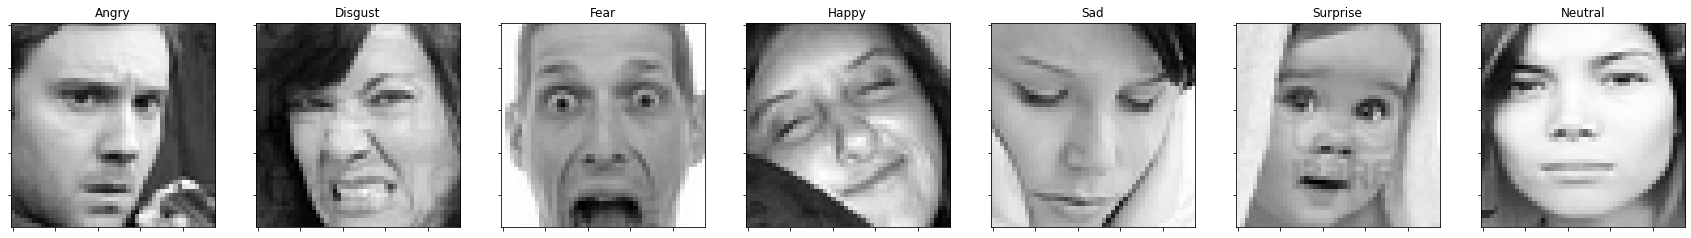

In [15]:
plot_all_emotions()

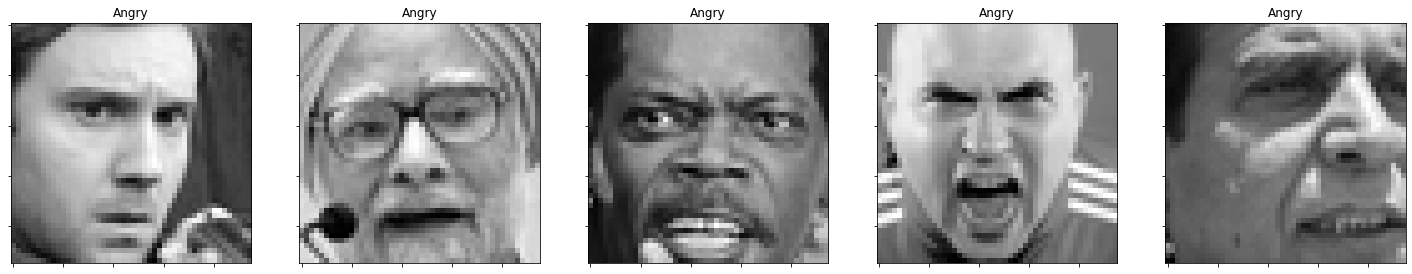

In [16]:
plot_examples(label=0)

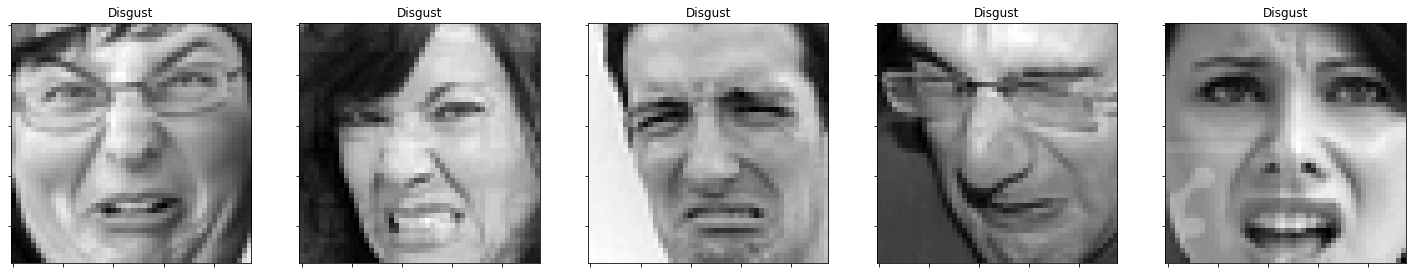

In [17]:
plot_examples(label=1)

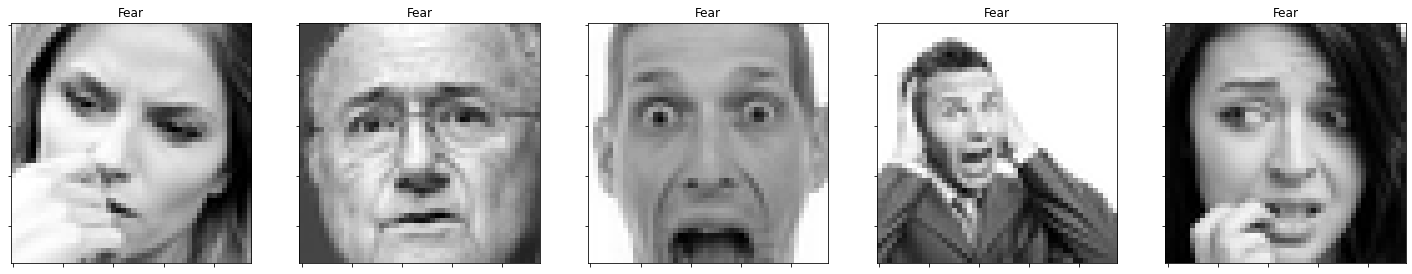

In [18]:
plot_examples(label=2)

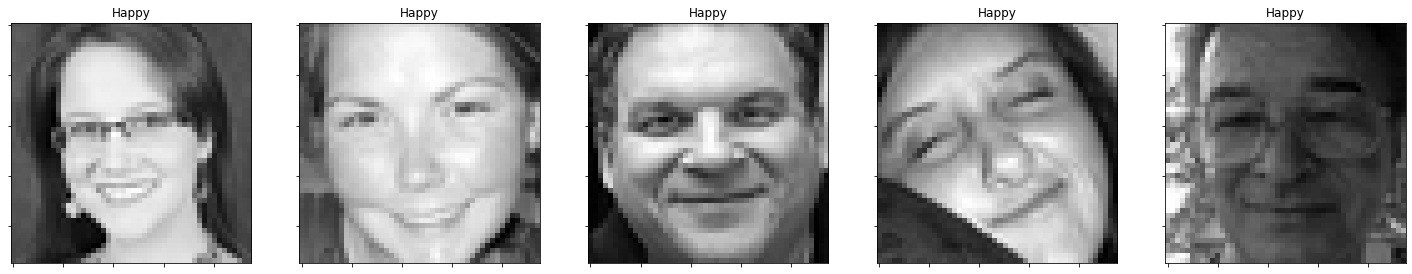

In [19]:
plot_examples(label=3)

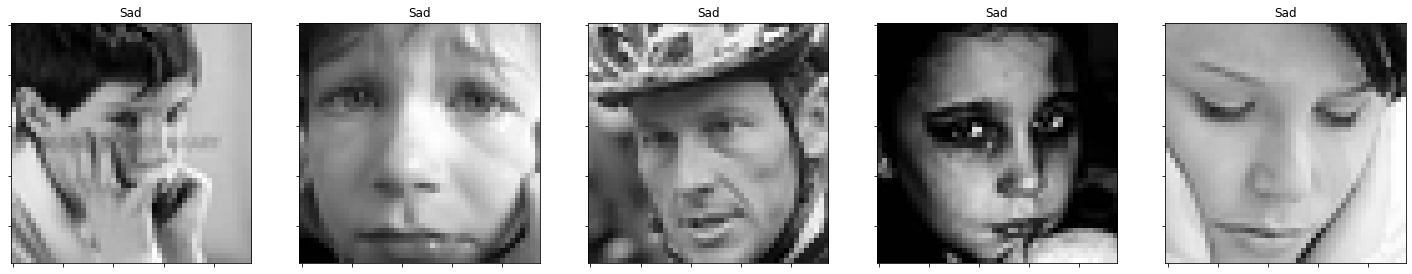

In [20]:
plot_examples(label=4)

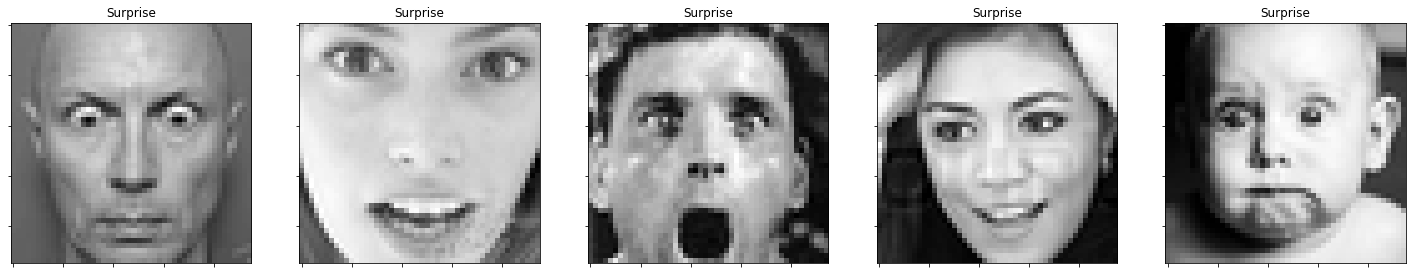

In [21]:
plot_examples(label=5)

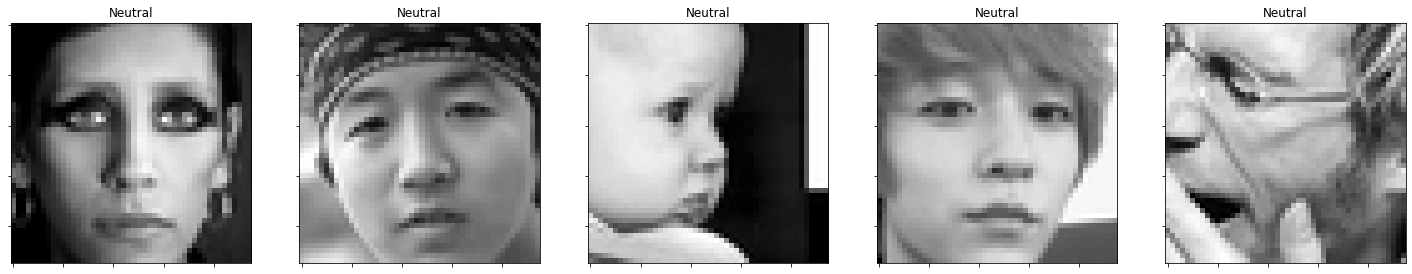

In [22]:
plot_examples(label=6)

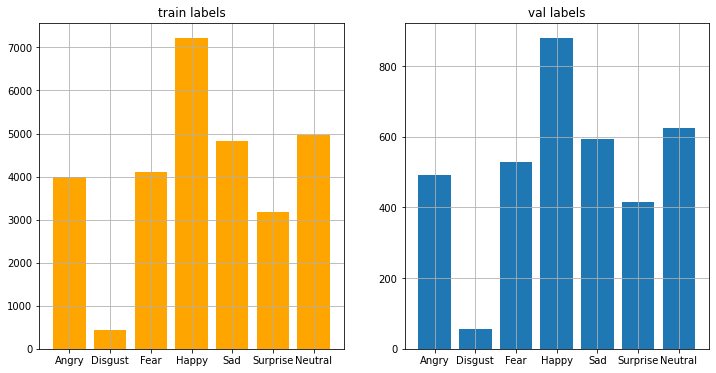

In [23]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [24]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [25]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

## Training the model


In [28]:
#model = VGGFace(model='resnet50')
model = VGGFace(include_top=False, input_shape=(48, 48, 1), pooling='avg') # pooling: None, avg or max
# summarize input and output shape
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

ValueError: Layer #1 (named "conv1_1"), weight <tf.Variable 'conv1_1/kernel:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
array([[[[ 0.05605944,  0.05491185, -0.01300508,  0.01685456,
           0.09453744, -0.02504537, -0.07360256, -0.09598181,
           0.05928437,  0.01027699,  0.03760237,  0.02060746,
          -0.09362264,  0.09967011, -0.04672435,  0.04252195,
          -0.08132672, -0.09238119,  0.0281238 ,  0.07644787,
           0.04844604,  0.06157297, -0.02392437, -0.04114486,
          -0.09994303,  0.03953019,  0.0987986 ,  0.03512438,
          -0.06935629, -0.04350999, -0.03810725, -0.02432306,
          -0.07705987, -0.05508862,  0.00211081,  0.05206828,
          -0.02740061,  0.02705407, -0.0493155 ,  0.00248801,
           0.06808732, -0.05089038,  0.09850538, -0.07571127,
          -0.07074003,  0.01547737, -0.08675182, -0.00016991,
           0.04784931,  0.01712229, -0.08168093,  0.00893732,
           0.03768975, -0.09809831,  0.09501344,  0.03749087,
          -0.0997772 ,  0.09820071, -0.05162979, -0.09312429,
           0.09528217,  0.01623549,  0.0835436 ,  0.00048832]],

        [[-0.04760209, -0.06335926, -0.03581867,  0.07402845,
           0.01168755,  0.08983934, -0.00346748, -0.07597385,
           0.02992757,  0.03895538,  0.06040801,  0.01936674,
          -0.09729277,  0.05740744, -0.05091931,  0.0517282 ,
          -0.02789682,  0.01070785, -0.04587099, -0.00960823,
          -0.00032613,  0.07063715, -0.09653146, -0.06422463,
          -0.07221515,  0.02712362, -0.0340156 , -0.06235374,
           0.09384388,  0.05050714,  0.01684981,  0.09773429,
          -0.01712716, -0.05850549,  0.07078168, -0.06231571,
           0.05097201, -0.08261341, -0.0641641 , -0.07107522,
           0.00532369, -0.05740812,  0.00097763,  0.03616197,
          -0.07414342,  0.05610768,  0.06114618,  0.01545955,
          -0.00663948, -0.02787876,  0.05294517, -0.06077737,
           0.04051106,  0.09025455, -0.09786523,  0.05091003,
          -0.05047657, -0.03580378, -0.07537012,  0.04261394,
          -0.08356899, -0.07401693,  0.0840514 ,  0.03955294]],

        [[-0.01923329,  0.05001831, -0.05239858,  0.01814452,
           0.05473015, -0.01257174, -0.03267941,  0.00552567,
           0.08981693,  0.07811868,  0.07863156,  0.08937714,
           0.02741188,  0.06677741,  0.0747886 , -0.06281275,
           0.04208037, -0.08230432,  0.0699304 , -0.01439261,
          -0.01039885, -0.01357598,  0.00201024, -0.02663251,
           0.0981299 ,  0.04546937, -0.05015297, -0.06445006,
           0.0920665 ,  0.09487312,  0.00212875,  0.09847443,
          -0.08468816,  0.02288318, -0.05369359,  0.01848806,
          -0.07069124, -0.01986282, -0.09540869,  0.05863214,
           0.06361109,  0.07646437,  0.03173123, -0.03150453,
          -0.08499327, -0.06766438, -0.05237859, -0.07825537,
          -0.09183577,  0.04930821, -0.00652708, -0.0410087 ,
          -0.0603294 , -0.00015847,  0.08443594, -0.06191504,
           0.09660305, -0.06325388, -0.02569793,  0.01194282,
           0.05669446,  0.028908  , -0.04562983, -0.04375077]]],


       [[[-0.06097611, -0.00216161, -0.05212839,  0.03165931,
           0.00919792,  0.06070858, -0.0006805 ,  0.00936665,
           0.06636553, -0.01372442, -0.09820598,  0.08255562,
           0.03683591, -0.009725  ,  0.06845944,  0.02524057,
           0.03067337, -0.08597194, -0.00819588, -0.00915232,
          -0.08555132, -0.00902898,  0.00719225,  0.0265734 ,
          -0.07818629,  0.06823842, -0.06586926, -0.09150014,
          -0.01815147,  0.06872804,  0.10100764, -0.05858934,
          -0.03988088, -0.02637137,  0.05612166, -0.08303043,
          -0.04370279,  0.0805012 ,  0.05106908, -0.0707987 ,
           0.07620633,  0.0610224 ,  0.04468629, -0.10007818,
          -0.04209001, -0.0963691 , -0.03167237, -0.09379576,
          -0.07024638, -0.02229263,  0.06475398,  0.07399343,
           0.06934632, -0.03428147, -0.05158565,  0.02047589,
           0.06405027, -0.03214217, -0.08453303,  0.06216359,
          -0.09393933, -0.07827075, -0.06304015, -0.02825923]],

        [[ 0.04816067,  0.00650045,  0.09705962,  0.02188735,
          -0.08604768, -0.04061962,  0.03078005, -0.0791996 ,
           0.04295039, -0.10089184,  0.00022922,  0.04919444,
           0.01934856,  0.08888423,  0.03391634, -0.08964586,
           0.02244731,  0.03515731, -0.05227052,  0.04533315,
          -0.03168358, -0.05921689, -0.00721871,  0.06815122,
           0.01380232, -0.0749482 ,  0.04520121, -0.0149205 ,
           0.07567938, -0.02302458, -0.03178702,  0.08041686,
           0.04572001, -0.03092376,  0.09531164,  0.00585274,
           0.03090833,  0.08280466,  0.04705147,  0.00382609,
           0.05982123,  0.04822533,  0.05449109, -0.02013104,
          -0.01179425,  0.0642432 ,  0.08322388, -0.07735469,
          -0.07588652,  0.03062025,  0.07328752, -0.02559152,
          -0.08426385,  0.02918582,  0.0999002 , -0.07146329,
          -0.01991075, -0.01746832, -0.00543094, -0.06251368,
          -0.04325139, -0.01592076, -0.03026787,  0.00628853]],

        [[-0.0569818 ,  0.04634134, -0.01873063, -0.04794652,
          -0.08937084,  0.04934296,  0.02710639, -0.09980584,
          -0.04741967, -0.04861096, -0.07954539, -0.04860517,
          -0.09082372, -0.00074692,  0.0241951 ,  0.05468249,
           0.08997141,  0.07479137,  0.02356151, -0.09460116,
          -0.08737323,  0.09001319,  0.09826608, -0.00995868,
           0.08323902,  0.00757413,  0.04507209,  0.07776812,
          -0.09147912,  0.05883396,  0.07499579,  0.05887423,
          -0.04171358, -0.085706  , -0.03268878,  0.06642084,
           0.0961981 , -0.05255155,  0.02173692, -0.07382517,
          -0.07732011,  0.08821987,  0.04527283, -0.10100716,
          -0.04181405, -0.09956045, -0.0263425 ,  0.07918689,
           0.03018869,  0.03137054,  0.02674189, -0.01953953,
          -0.08628836, -0.06097655,  0.05811642,  0.05759908,
          -0.00508475,  0.07222298,  0.09751745, -0.01729459,
          -0.03896917,  0.05827253,  0.07976983,  0.07820216]]],


       [[[-0.01329031,  0.01658116, -0.00209024, -0.0318064 ,
           0.08164923,  0.09747095, -0.00867996, -0.09897187,
           0.02579971, -0.07946096, -0.06750735, -0.05434918,
          -0.09352352, -0.00385414, -0.10106619, -0.08096011,
           0.08277726, -0.06260265,  0.00254149, -0.08975096,
           0.06024525,  0.05963746,  0.00736953,  0.07166952,
           0.06285539, -0.09049515, -0.03300987, -0.04510241,
          -0.02171437,  0.02828443, -0.03203584, -0.0847486 ,
           0.08178698,  0.06341371, -0.00247623, -0.05494956,
          -0.08383305,  0.08086106,  0.0468069 ,  0.06974907,
           0.03846887,  0.04747306, -0.09511271, -0.03154684,
          -0.0030903 , -0.04434777,  0.01082008, -0.00274159,
          -0.02460264, -0.09461451,  0.06350145, -0.014582  ,
          -0.00612076,  0.06163599, -0.03038044, -0.05474604,
           0.04634006, -0.02831599, -0.02443299, -0.07036582,
           0.06793818, -0.09482986, -0.03568208,  0.09369072]],

        [[-0.01404368, -0.08843479, -0.02637616,  0.00435135,
           0.00716303, -0.09902859, -0.02089608, -0.09277631,
           0.04362695,  0.08320637,  0.00071207, -0.02192934,
          -0.01130057, -0.08820266, -0.03085973, -0.08512641,
          -0.0067555 , -0.05846427, -0.05288756, -0.03108061,
          -0.08107466,  0.08759452,  0.07057729,  0.01661584,
          -0.04928778, -0.01267559,  0.00783517,  0.03460515,
           0.03156179,  0.03502564,  0.07342348, -0.08850457,
           0.00308122,  0.05181061, -0.02001387,  0.05826318,
          -0.06600679, -0.07145005,  0.08927846, -0.08984308,
           0.01468714,  0.06045118, -0.08663833,  0.09118876,
          -0.02019105, -0.00249465, -0.02551115,  0.05497   ,
           0.09564148, -0.03108069, -0.0227393 ,  0.00868857,
          -0.07369652,  0.0780731 , -0.06273709, -0.09109819,
          -0.02584361, -0.05556574, -0.04348111, -0.03514077,
           0.08356752, -0.03756435, -0.09168589,  0.08360222]],

        [[-0.00441188, -0.04284389,  0.06661871,  0.0605517 ,
          -0.08439407,  0.07869802,  0.02208544, -0.02055251,
          -0.01464884,  0.01111803, -0.06079521,  0.08878204,
          -0.01465359, -0.03686889,  0.07515353,  0.01150977,
          -0.07212898, -0.06640853,  0.00943889, -0.06516385,
           0.09473714,  0.08654822, -0.04156847, -0.01372795,
           0.04952714, -0.1004981 , -0.03363811,  0.04292141,
           0.05877028,  0.015136  , -0.0525167 ,  0.03902973,
           0.01561616,  0.02304243,  0.01538562, -0.04277357,
           0.06873594, -0.07084675, -0.03149009, -0.04272076,
           0.01002624,  0.04111953,  0.04049626, -0.00951377,
           0.02340787, -0.00690873, -0.02310859,  0.03579825,
          -0.01138797,  0.0708618 , -0.03213167, -0.05307427,
          -0.0231853 ,  0.05845335,  0.01828448,  0.06725189,
           0.04290983, -0.06609575, -0.00584017,  0.03534445,
           0.01297405, -0.00346016,  0.00063981,  0.0007773 ]]]],
      dtype=float32)> has shape (3, 3, 1, 64), but the saved weight has shape (64, 3, 3, 3).

In [27]:
# perform prediction

train_images.shape

(28709, 48, 48, 1)